In the following code we will do the following:
- Cleaning the dataset
- Applying some Hypothesis Tests to determine if some intependent variables can help as predict possible strokes.
- Predict using Random Forest Classifier.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **Data Preprocessing**
## Before we start applying some simple Hypothesis testing we must clean our data with the following:
* We will drop id column.
* The bmi column has some missing values, so we must fill this empty values.
* The gender column has a value 'other', we change it to the most frequent.
* Binary encoding to the gender, ever_maried and Residence type columns.
* From Descriptive Statistics we have the conclusion that our data is unblanced, so we perform SMOTE to balance the data.


In [4]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline

dataset['gender'].replace('Other', np.nan, inplace=True)

# Create transformation
transformation = ColumnTransformer([
    ('numerical', make_pipeline(SimpleImputer(strategy='mean'),
                                StandardScaler()), ['bmi']),
    ('gender_transform', make_pipeline(SimpleImputer(strategy='most_frequent'),
                                        OneHotEncoder(sparse=False, drop='first')), ['gender']),
    ('binary_encoding', OneHotEncoder(sparse=False, drop='first'), ['ever_married', 'Residence_type']),
    ('categorical_encoding', OneHotEncoder(sparse=False), ['work_type', 'smoking_status']),
    ('numeric_standardization', StandardScaler(),['age','avg_glucose_level'])
], remainder='passthrough')

# Create the Pipeline
pipeline = Pipeline([
    ('Transformation', transformation),
    ("Scaler", StandardScaler())
])

# Apply transformation to the data
transformed_data = transformation.fit_transform(dataset)

# Extract the names of the columns
transformed_column_names = (['BMI', 'Gender'] +
                             ['Married', 'Residence_type','Private Sector','Self-employed','Govt_job','Children','Never_worked','Formerly_smoked', 'Never_smoked', 'Smokes',
                             'Unknown',	] +
                             dataset.columns.drop(['bmi', 'gender', 'ever_married', 'Residence_type','work_type','smoking_status']).tolist())

# Create a new DataFrame based on the transformed data
transformed_dataset = pd.DataFrame(transformed_data, columns=transformed_column_names)
transformed_dataset


/tmp/ipykernel_18/1770190576.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['gender'].replace('Other', np.nan, inplace=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `spar

,BMI,Gender,Married,Residence_type,Private Sector,Self-employed,Govt_job,Children,Never_worked,Formerly_smoked,Never_smoked,Smokes,Unknown,id,age,hypertension,heart_disease,avg_glucose_level,stroke
0,1.001234e+00,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.051434,2.706375,9046.0,0.0,1.0,1.0
1,4.615554e-16,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.786070,2.121559,51676.0,0.0,0.0,1.0
2,4.685773e-01,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.626390,-0.005028,31112.0,0.0,1.0,1.0
3,7.154182e-01,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.255342,1.437358,60182.0,0.0,0.0,1.0
4,-6.357112e-01,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.582163,1.501184,1665.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,4.615554e-16,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.626390,-0.494658,18234.0,1.0,0.0,0.0
5106,1.442949e+00,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.670617,0.420775,44873.0,0.0,0.0,0.0
5107,2.217363e-01,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.363842,-0.511443,19723.0,0.0,0.0,0.0
5108,-4.278451e-01,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.343796,1.328257,37544.0,0.0,0.0,0.0


## Apply SMOTE to Balance the data.

In [5]:
#transformed_dataset['work_type'].unique()

In [6]:
from imblearn.over_sampling import SMOTE

# Define the Dependent and independent variable.
X = transformed_dataset.iloc[:,:-1]
y = transformed_dataset.iloc[:,-1]
# Now, X should contain the transformed features
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled

,BMI,Gender,Married,Residence_type,Private Sector,Self-employed,Govt_job,Children,Never_worked,Formerly_smoked,Never_smoked,Smokes,Unknown,id,age,hypertension,heart_disease,avg_glucose_level
0,1.001234e+00,1.000000,1.0,1.000000,0.00000,0.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.051434,2.706375,9046.000000,0.000000,1.0
1,4.615554e-16,0.000000,1.0,0.000000,0.00000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.786070,2.121559,51676.000000,0.000000,0.0
2,4.685773e-01,1.000000,1.0,0.000000,0.00000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,1.626390,-0.005028,31112.000000,0.000000,1.0
3,7.154182e-01,0.000000,1.0,1.000000,0.00000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.255342,1.437358,60182.000000,0.000000,0.0
4,-6.357112e-01,0.000000,1.0,0.000000,0.00000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,1.582163,1.501184,1665.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9717,-8.168430e-02,0.000000,1.0,0.871507,0.00000,0.0,0.871507,0.128493,0.0,0.000000,0.871507,0.128493,0.000000,0.965451,-0.100587,1821.871298,0.128493,0.0
9718,1.216435e+00,0.000000,1.0,1.000000,0.96962,0.0,0.030380,0.000000,0.0,0.000000,0.030380,0.969620,0.000000,1.239093,3.368889,71290.969555,0.000000,0.0
9719,1.957335e+00,0.287246,1.0,0.712754,0.00000,0.0,0.287246,0.712754,0.0,0.000000,0.000000,0.712754,0.287246,0.743740,2.975066,13754.718889,0.712754,0.0
9720,5.040063e-02,0.000000,1.0,0.000000,0.00000,0.0,0.046258,0.953742,0.0,0.046258,0.953742,0.000000,0.000000,1.372519,-0.606687,27165.304678,0.000000,0.0


## After smoting we can see that in the binaries columns we don't have only binaries values.
## We will use threshold to create only binary values.
## We will also round the age column and BMI



In [7]:
# Round the Age and BMI
'''X_resampled['age'] = X_resampled['age'].round()
X_resampled['BMI'] = X_resampled['BMI'].round(2)
X_resampled['avg_glucose_level'] = X_resampled['avg_glucose_level'].round(2)'''

# Define the threshold
threshold = 0.5

# Create a copy of your Resampled X dataset
X_binary_rounded = X_resampled.copy()
# Create a list of column you want only binaries values
binary_columns = ['Gender','Residence_type','Private Sector',  'Govt_job','Children','Never_worked', 'Formerly_smoked'
                    ,'Never_smoked', 'Smokes', 'Unknown', 'heart_disease']


for col in binary_columns:
  X_binary_rounded[col] = X_binary_rounded[col].apply(lambda x: 1 if x >= threshold else 0)

X_binary_rounded.dtypes 

BMI                  float64
Gender                 int64
Married              float64
Residence_type         int64
Private Sector         int64
Self-employed        float64
Govt_job               int64
Children               int64
Never_worked           int64
Formerly_smoked        int64
Never_smoked           int64
Smokes                 int64
Unknown                int64
id                   float64
age                  float64
hypertension         float64
heart_disease          int64
avg_glucose_level    float64
dtype: object

In [8]:
# Assuming X_binary_rounded is your DataFrame and 'Unknown' is a column name
unknown_counts = X_binary_rounded['Unknown'].value_counts()

# Print the counts
print(unknown_counts)

Unknown
0    8154
1    1568
Name: count, dtype: int64


# Prepare for Chi-Squared hypothesis testing.
## Create DataFrame for the work types and create a new DataFrame with Stroke and the work types values.

In [9]:
# DataFrame for work_types
work_types = X_resampled.loc[:,['Formerly_smoked',	'Never_smoked'	,'Smokes',	'Unknown']]
concatenated_data = pd.concat([work_types, y], axis=1)

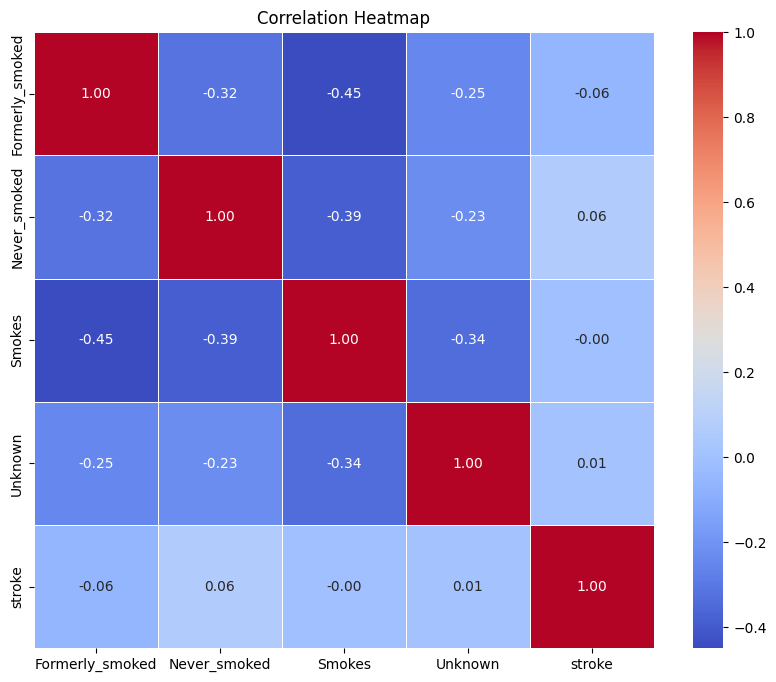

In [10]:

# Calculate the correlation matrix
correlation_matrix = concatenated_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Null Hypothesis (H0): There is no significant difference in stroke risk distribution among the different work types.
## Alternative Hypothesis (H1): There is a significant difference in stroke risk distribution among the different work types.

In [11]:
from scipy.stats import chi2_contingency

# Initialize an empty dictionary to store the chi-square statistics and p-values
results = {}

# Iterate through each column except for the 'stroke' column
for column in concatenated_data.columns[:-1]:
    # Contingency table of stroke by the current column
    contingency_table = pd.crosstab(concatenated_data['stroke'], concatenated_data[column])

    # Perform chi-square test
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

    # Store the chi-square statistic and p-value in the results dictionary
    results[column] = {'chi2_stat': chi2_stat, 'p_val': p_val}

# Print the results
for column, result in results.items():
    print(f"Chi-square Test for {column}:")
    print("Chi-square statistic:", result['chi2_stat'])
    print("p-value:", result['p_val'])

    # Interpret the results
    if result['p_val'] > 0.05:
        print("Fail to reject the Null Hypothesis: There is no significant difference in stroke risk among different categories of", column)
    else:
        print("Reject the Null Hypothesis: There is a significant difference in stroke risk among different categories of", column)
    print()


Chi-square Test for Formerly_smoked:
Chi-square statistic: 15.402705076161274
p-value: 8.686385705628018e-05
Reject the Null Hypothesis: There is a significant difference in stroke risk among different categories of Formerly_smoked

Chi-square Test for Never_smoked:
Chi-square statistic: 20.510528545500733
p-value: 5.930414820659066e-06
Reject the Null Hypothesis: There is a significant difference in stroke risk among different categories of Never_smoked

Chi-square Test for Smokes:
Chi-square statistic: 0.05191850370394257
p-value: 0.8197579391268933
Fail to reject the Null Hypothesis: There is no significant difference in stroke risk among different categories of Smokes

Chi-square Test for Unknown:
Chi-square statistic: 0.3015133498043404
p-value: 0.5829352382079063
Fail to reject the Null Hypothesis: There is no significant difference in stroke risk among different categories of Unknown



## From the above result we must drop the following columns because they will not help us predict strokes.
- Smokes.
- Uknown.

In [12]:
# Create a copy of the dataset.
preprocessed_dataset = transformed_dataset.copy()
# Drop the two columns.
preprocessed_dataset.drop(['Smokes', 'Unknown'], axis=1, inplace=True)


# Chi-Squared test to find if there are association between the marital status and stroke.
## Null Hypothesses: There is no association between marital status and stroke.
## Alternative Hypothesis: There is an association between marital and stroke.

In [13]:
# Create a dataframe for the columns we want for this Hypothesis tests.
smoke_columns = X_resampled.loc[:,['Private Sector',	'Self-employed',	'Govt_job',	'Children']]
concatenated_data = pd.concat([smoke_columns, y], axis=1)

# Initialize an empty dictionary to store the chi-square statistics and p-values
results = {}

# Iterate through each column except for the 'stroke' column
for column in concatenated_data.columns[:-1]:
    # Contingency table of stroke by the current column
    contingency_table = pd.crosstab(concatenated_data['stroke'], concatenated_data[column])

    # Perform chi-square test
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

    # Store the chi-square statistic and p-value in the results dictionary
    results[column] = {'chi2_stat': chi2_stat, 'p_val': p_val}

# Print the results
for column, result in results.items():
    print(f"Chi-square Test for {column}:")
    print("Chi-square statistic:", result['chi2_stat'])
    print("p-value:", result['p_val'])

    # Interpret the results
    if result['p_val'] > 0.05:
        print("Fail to reject the Null Hypothesis: There is no significant difference in stroke risk among different categories of", column)
    else:
        print("Reject the Null Hypothesis: There is a significant difference in stroke risk among different categories of", column)
    print()

Chi-square Test for Private Sector:
Chi-square statistic: 0.008889583663194358
p-value: 0.9248830918252636
Fail to reject the Null Hypothesis: There is no significant difference in stroke risk among different categories of Private Sector

Chi-square Test for Self-employed:
Chi-square statistic: 0.3222432130658206
p-value: 0.5702626644660544
Fail to reject the Null Hypothesis: There is no significant difference in stroke risk among different categories of Self-employed

Chi-square Test for Govt_job:
Chi-square statistic: 0.6148979363597604
p-value: 0.43294958806649464
Fail to reject the Null Hypothesis: There is no significant difference in stroke risk among different categories of Govt_job

Chi-square Test for Children:
Chi-square statistic: 18.970346995803315
p-value: 1.3276583088212079e-05
Reject the Null Hypothesis: There is a significant difference in stroke risk among different categories of Children



# Perform a t_test to determine the significance of the BMI.
### Null Hypothesis: There is no significant difference in mean BMI between indiiduals who have had a stroke and those who have not.
### Alternative Hypothesis: There is significant differnece in mena BMI between individuals who have had a stroke and those who have not.

In [14]:
from scipy.stats import ttest_ind

# Extract BMI data for individuals with and without stroke
bmi_stroke = dataset[dataset['stroke'] == 1]['bmi']
bmi_no_stroke = dataset[dataset['stroke'] == 0]['bmi']

# Perform two-sample t-test
t_stat, p_val = ttest_ind(bmi_stroke, bmi_no_stroke, equal_var=False)
print("Two-Sample T-Test:")
print("t-statistic:", t_stat)
print("p-value:", p_val)

if p_val >0.05:
  print("Fail to reject the null Hypothesis.")
elif p_val < 0.05:
  print("Reject the null hypothesis")

Two-Sample T-Test:
t-statistic: nan
p-value: nan


# Chi-Square test to find if there are association between Residence type and stroke.
## Null Hypothesis (H0): There is no diference between the diffent desidence
## Alternative Hypothesis (Ha): There is a difference between the diffenent residence.

In [15]:
contingency_table = pd.crosstab(transformed_dataset['Residence_type'], transformed_dataset['stroke'])

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-Squared Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

if p > 0.05:
  print("\nFail to reject the Null Hypothesis.")
elif p < 0.05:
  print("\nReject the Null Hypothesis.")

Chi-Squared Statistic: 1.0816367471627524
p-value: 0.29833169286876987
Degrees of Freedom: 1
Expected Frequencies Table:
[[2391.49784736  122.50215264]
 [2469.50215264  126.49784736]]

Fail to reject the Null Hypothesis.


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

pca = PCA(n_components= 10)
selector = SelectKBest(f_classif, k = 5)

pipeline = Pipeline([
    ('pca',pca),
    ('feature_selector',selector)
])

pipelined_X = pipeline.fit_transform(X_binary_rounded,y_resampled)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pipelined_X, y_resampled, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Train the Random Forest Classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8858611825192803
Confusion Matrix:
[[811 164]
 [ 58 912]]
